In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [7]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

import keras.backend as K
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

#### Preprocessing

In [31]:
def preprocess(image=None,
               path_to_image='content.jpg',
               dims=(512, 512)):
    # load
    if image is None:
        content_image = Image.open(path_to_image)
    else:
        content_image = image
        
    # reshape and convert to array
    content_image = content_image.resize(dims)
    content_image = content_image.rotate((-90))
    content_array = np.asarray(content_image,dtype='float32')
    content_array = np.expand_dims(content_array,axis=0)
    
     # something
    content_array[:, :, :, 0] -= 103.939
    content_array[:, :, :, 1] -= 116.779
    content_array[:, :, :, 2] -= 123.68
    content_array = content_array[:, :, :, ::-1]
    return backend.variable(content_array)

#### Loss function

In [32]:
class StyleTransferLoss(object):
    def __init__(model=None,
                 height=512,
                 width=512,
                 combination_image=None,
                 feature_layers=['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2'],
                 content_weight=0.005,
                 style_weight=5.0,
                 total_variation_weight=1.0,
                 abstract_factor=5):
        
        self.height = height
        self.width = width
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.total_variation_weight = total_variation_weight
        self.abstract_factor = abstract_factor
        self.feature_layers = feature_layers
        
        # load model
        if model is None:
            model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
        self.layers = dict([(layer.name, layer.output) for layer in model.layers])
        
        # load keras variable
        if combination_image is not None:
            self.combination_image = combination_image
        else:
            print('You must pass a valid placeholder for the generated image.')
        
    def compute_loss(self):
        loss = K.variable(0.)
        loss += self.content_loss()
        
        for layer_name in self.feature_layers:
            loss += self.style_loss()
        
        loss += total_variation_weight * total_variation_loss(self.combination_image, height, width)
        return loss
        
    def content_loss(self):
        layer_features = layers['block{}_conv2'.format(self.abstract_factor)]
        content_image_features = layer_features[0,:,:,:]
        combination_features = layer_features[2,:,:,:]
        return self.content_weight * content_loss(content_image_features, combination_features)
    
    def style_loss(self):
        layer_features = self.layers[layer_name]
        style_features = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]
        return style_loss(style_features, combination_features, self.height, self.width)
    
def content_loss(content, combination):
    """
    Content loss function. Used to extrapolate contours from the content image.
    """
    return K.sum(K.square(content - combination))

def gram_matrix(x):
    """
    Hermitian matrix of inner products. Used to compute linear dependence of features.
    """
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination, height, width, channels=3):
    """
    Style loss function.
    """
    S = gram_matrix(style)
    C = gram_matrix(combination)
    size = height * width
    st = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

def total_variation_loss(x, height, width):
    """
    Enforces smoothness across the final image.
    """
    a = K.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [26]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

#### Train

In [25]:
# load and preprocess images
content_image=preprocess(path_to_image='content.jpg', dims=dims)
style_image=preprocess(path_to_image='style/Unknown-54_o.jpg', dims=dims)

# define variables and load model
height = 512
width = 512
dims = (height, width)
input_tensor = K.concatenate([content_image, style_image, combination_image],axis=0)
combination_image = K.placeholder((1, height, width, 3))
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

# prepare loss function
loss_function = StyleTransferLoss(model=model,
                                  height=height,
                                  width=width,
                                  combination_image=combination_image,
                                  feature_layers=['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2'],
                                  content_weight=0.005,
                                  style_weight=5.0,
                                  total_variation_weight=1.0,
                                  abstract_factor=5)

# define gradient and outputs
grads = K.gradients(loss_function.compute_loss(), 
                    loss_function.combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
    
f_outputs = K.function([combination_image], outputs)

# evaluate
evaluator = Evaluator()
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.0
iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    end_time = time.time()
    print('Iteration {:.2f} completed in {:.2f} with loss {:.2f}.'.format(i, end_time - start_time, evaluator.loss))

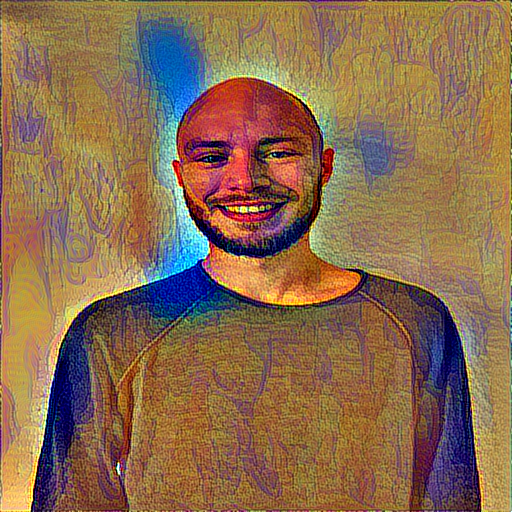

In [29]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)

#### Load model

In [11]:
# weights
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

# check layers
layers = dict([(layer.name, layer.output) for layer in model.layers])
print([i for i in layers])

['input_2', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [24]:
# initialize the loss
loss = K.variable(0.)

# compute content loss
layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]
loss += content_weight * content_loss(content_image_features, combination_features)

# compute style loss
# 0 - 5 uses feature layers with increasing scale of object detection
feature_scales = {}
feature_losses = {'1': loss,
                  '2': loss,
                  '3': loss,
                  '4': loss,
                  '5': loss}

max_feature_layers = ['block1_conv2', 'block2_conv2',
                      'block3_conv3', 'block4_conv3',
                      'block5_conv3']

# cycle through all hierarchies of feature correlation maps to find the granularity we want
for i, features in enumerate(max_feature_layers):
    feature_scales[i+1] = max_feature_layers[:i+1]

for key, feature_layer in feature_scales.items():
    for layer_name in feature_layer:
        layer_features = layers[layer_name]
        style_features = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]
        sl = style_loss(style_features, combination_features, height, width)
        feature_losses[key] += (style_weight / len(feature_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image, height, width)